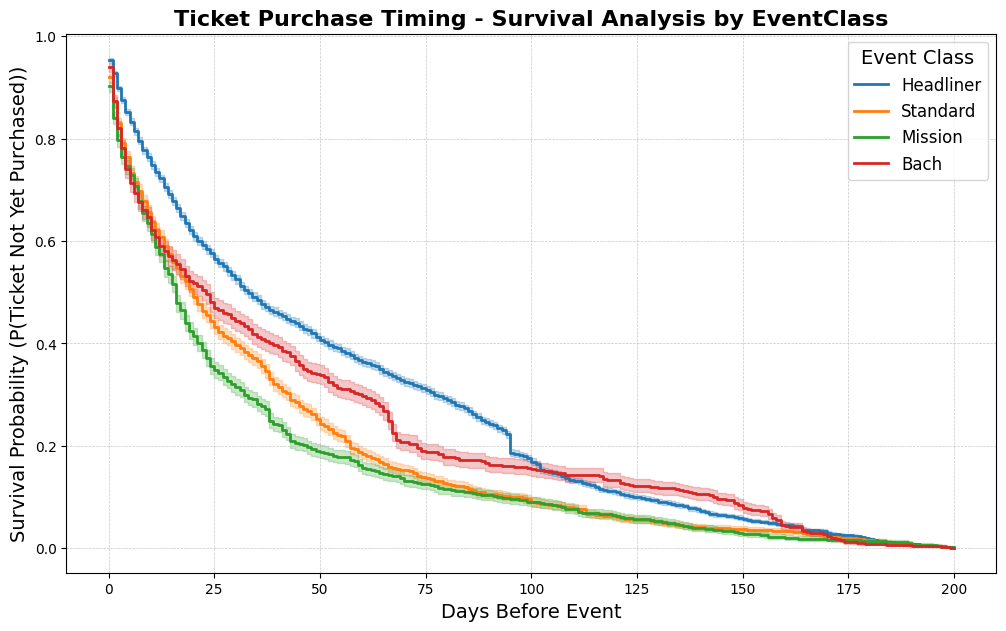

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# set and change to working directory
default_data_dir = '/Users/antho/Documents/WPI-MW'
data_dir = default_data_dir
os.chdir(data_dir)

# Load data file
file_path = "anon_DataMerge.csv"  # Change this to your actual file path
df = pd.read_csv(file_path, parse_dates=["CreatedDate", "EventDate"])

# Filter Post-Pandemic events (after July 1, 2022 and ending with the 2/14/2025 concert)
df = df[(df["EventDate"] >= "2022-07-01") & (df["EventDate"] <= "2025-02-15")].copy()

# Remove venues that credited all at once before the event a they can skew the results.
# for now, that's only Hanover.
df = df[~df["EventVenue"].isin(['The Hanover Theatre'])]

# Calculate 'Days Before Event' (time before event when the ticket was purchased)
df["DaysBeforeEvent"] = (df["EventDate"] - df["CreatedDate"]).dt.days

# Remove negative values (sales recorded after the event)
df = df[df["DaysBeforeEvent"] >= 0]

# Remove rows where EventClass is NaN. These are often non-events.
df = df.dropna(subset=["EventClass"])

# Reassign 'Local Favorite' to 'Headliner' - this has been a TODO for a while now.
df["EventClass"] = df["EventClass"].replace("Local Favorite", "Headliner")

# Limit to purchases made within 200 days before the event.
# This allows us to see subscriptions, but is probably execessive.
df = df[df["DaysBeforeEvent"] <= 200]

# Only include Live, Complete events.
df = df[(df['EventStatus'] == 'Complete') & (df['EventType'] == 'Live')]

"""
# TODO. Consider using ticket total, rather than quantity.
df = df[["AccountId", "EventName", "TicketTotal", "EventClass", "DaysBeforeEvent"]]
# Remove rows with NaN or zero TicketTotal to prevent errors
df = df[df["TicketTotal"].notna() & (df["TicketTotal"] > 0)]
# Expand dataset to reflect TicketTotal
df = df.loc[df.index.repeat(df["TicketTotal"].astype(int))]  # Replicate based on ticket revenue
"""

# select columns for KMF. Using quantity and duplicating rows for quantity so KMF considers that.
df = df[["AccountId", "EventName", "Quantity", "EventClass", "DaysBeforeEvent"]]
#print(df.shape)
df = df.loc[df.index.repeat(df["Quantity"])]
#print(df.shape)

# Set plot style
plt.figure(figsize=(12, 7))
plt.style.use("default")  # Ensures a clean background

kmf = KaplanMeierFitter()

colors = plt.cm.tab10.colors  # Get distinct colors

# Group by EventClass
event_classes = df["EventClass"].unique()

for i, event_class in enumerate(event_classes):
    subset = df[df["EventClass"] == event_class]
    kmf.fit(subset["DaysBeforeEvent"], event_observed=np.ones(len(subset)))  # All transactions are observed
    kmf.plot(label=event_class, color=colors[i % len(colors)], linewidth=2)  # Use distinct colors

# Format the plot
plt.title("Ticket Purchase Timing - Survival Analysis by EventClass", fontsize=16, fontweight="bold")
plt.xlabel("Days Before Event", fontsize=14)
plt.ylabel("Survival Probability (P(Ticket Not Yet Purchased))", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Light grid lines
plt.legend(title="Event Class", fontsize=12, title_fontsize=14, loc="upper right", frameon=True)
plt.gca().set_facecolor("white")  # Set white background

# Show the plot
plt.show()
del df
